In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import cv2 as cv
import random
from torchvision import models, transforms
import PIL

## Load the pre-trained VGG-16 Model

We will load the VGG-16 model from `torchvision.models` module.

In [4]:
# load the pretrained VGG-16 model for image classification
model = models.vgg16(pretrained=True)
# don't need to find gradients with respect to the prams of the network
for param in model.parameters():
    param.requires_grad = False
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
def rescale(x):
  low, high = x.min(), x.max()
  x_rescaled = (x - low) / (high - low)
  return x_rescaled

def preprocess(image, size = 224):
  transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize(size),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
      transforms.Lambda(lambda x: x[None]),
  ])
  return transform(image)

def deprocess(image):
  transform = transforms.Compose([
      transforms.Lambda(lambda x: x[0]),
      transforms.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
      transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
      transforms.Lambda(rescale),
      transforms.ToPILImage(),
  ])
  return transform(image)

# Neural Style Transfer
In this part we will implement the style transfer technique from ["Image Style Transfer Using Convolutional Neural Networks" (Gatys et al., CVPR 2015)](http://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf).

The general idea is to take two images, and produce a new image that reflects the content of one but the artistic "style" of the other. We will do this by first formulating a loss function that matches the content and style of each respective image in the feature space of a deep network, and then performing gradient descent on the pixels of the image itself.

The deep network we use as a feature extractor is VGG-16 as we used in the previous part but you could use any network.

In [6]:
# We provide this helper code which takes an image, a model (cnn), and returns a dictionary of
# feature maps, one per layer.
def extract_features(x, cnn):
  """
  Use the CNN to extract features from the input image x.
  
  Inputs:
  - x: A PyTorch Tensor of shape (N, C, H, W) holding a minibatch of images that
    will be fed to the CNN.
  - cnn: A PyTorch model that we will use to extract features.
  
  Returns:
  - features: A dictionary of feature for the input images x extracted using the cnn model.
    features[name] is a PyTorch Tensor of shape (N, C_i, H_i, W_i); recall that features
    from different layers of the network may have different numbers of channels (C_i) and
    spatial dimensions (H_i, W_i).
  """
  features = {}
  prev_feat = x
  for i, module in enumerate(cnn._modules.values()):
    if type(module) == nn.Sequential and i == 0:
      for layer in module.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
        next_feat = layer(prev_feat)
        features[name] = next_feat
        prev_feat = next_feat
  return features

## Computing Loss

We're going to compute the three components of our loss function now. The loss function is a weighted sum of three terms: content loss + style loss + total variation loss. You'll fill in the functions that compute these weighted terms below.

### A: Content loss

We can generate an image that reflects the content of one image and the style of another by incorporating both in our loss function. We want to penalize deviations from the content of the content image and deviations from the style of the style image. We can then use this hybrid loss function to perform gradient descent **not on the parameters** of the model, but instead **on the pixel values** of our original image.

Let's first write the content loss function. Content loss measures how much the feature map of the generated image differs from the feature map of the source image. We only care about the content representation of one layer of the network (say, layer $\ell$), that has feature maps $A^\ell \in \mathbb{R}^{1 \times C_\ell \times H_\ell \times W_\ell}$. $C_\ell$ is the number of filters/channels in layer $\ell$, $H_\ell$ and $W_\ell$ are the height and width. We will work with reshaped versions of these feature maps that combine all spatial positions into one dimension. Let $F^\ell \in \mathbb{R}^{C_\ell \times M_\ell}$ be the feature map for the current image and $P^\ell \in \mathbb{R}^{C_\ell \times M_\ell}$ be the feature map for the content source image where $M_\ell=H_\ell\times W_\ell$ is the number of elements in each feature map. Each row of $F^\ell$ or $P^\ell$ represents the vectorized activations of a particular filter, convolved over all positions of the image. Finally, let $w_c$ be the weight of the content loss term in the loss function.

Then the content loss is given by:

$L_c = w_c \times \sum_{i,j} (F_{ij}^{\ell} - P_{ij}^{\ell})^2$

In [7]:
def content_loss(content_weight, content_current, content_original):
    """
    Compute the content loss for style transfer.
    
    Inputs:
    - content_weight: Scalar giving the weighting for the content loss.
    - content_current: features of the current image; this is a PyTorch Tensor of shape
      (1, C_l, H_l, W_l).
    - content_target: features of the content image, Tensor with shape (1, C_l, H_l, W_l).
    
    Returns:
    - scalar content loss
    """
    loss = torch.sum( content_weight * (content_current - content_original)**2 )
    return loss

### B: Style loss

Now we can tackle the style loss. For a given layer $\ell$, the style loss is defined as follows:

First, compute the Gram matrix $G$ which represents the correlations between the values in each channel of the feature map (i.e. the "responses" of the filter responsible for that channel), where $F$ is as above. The Gram matrix is an approximation of the covariance matrix -- it tells us how every channel's values (i.e. that filter's activations) correlate with every other channel's values. If we have $C$ channels, matrix $G$ will be of shape $(C, C)$ to capture these correlations.

We want the activation statistics of our generated image to match the activation statistics of our style image, and matching the (approximate) covariance is one way to do that. There are a variety of ways you could do this, but the Gram matrix is nice because it's easy to compute and in practice shows good results.

Given a feature map $F^\ell$ of shape $(C_\ell, H_\ell, W_\ell)$, we can flatten the height and width dimensions so they're just 1 dimension $M_\ell = H_\ell \times W_\ell$: the new shape of $F^\ell$ is $(C_\ell, M_\ell)$. Then, the Gram matrix has shape $(C_\ell, C_\ell)$ where each element is given by the equation:

$$G_{ij}^\ell  = \sum_k F^{\ell}_{ik} F^{\ell}_{jk}$$

Assuming $G^\ell$ is the Gram matrix from the feature map of the current image, $A^\ell$ is the Gram Matrix from the feature map of the source style image, and $w_\ell$ a scalar weight term, then the style loss for the layer $\ell$ is simply the weighted Euclidean distance between the two Gram matrices:

$$L_s^\ell = w_\ell \sum_{i, j} \left(G^\ell_{ij} - A^\ell_{ij}\right)^2$$

In practice we usually compute the style loss at a set of layers $\mathcal{L}$ rather than just a single layer $\ell$; then the total style loss is the sum of style losses at each layer:

$$L_s = \sum_{\ell \in \mathcal{L}} L_s^\ell$$

In [8]:
def gram_matrix(features, normalize=True):
    """
    Compute the Gram matrix from features.
    
    Inputs:
    - features: PyTorch Tensor of shape (N, C, H, W) giving features for
      a batch of N images.
    - normalize: optional, whether to normalize the Gram matrix
        If True, divide the Gram matrix by the number of neurons (H * W * C)
    
    Returns:
    - gram: PyTorch Tensor of shape (N, C, C) giving the
      (optionally normalized) Gram matrices for the N input images.
    """
    N, C, H, W = features.size()
    features = features.view(N*C,H*W) #reshape it
    gram_matrix = torch.mm(features, features.t())
    if (normalize):
        gram_matrix /= float(H*W*C)
    return gram_matrix

In [9]:
def style_loss(feats, style_layers, style_targets, style_weights):
    """
    Computes the style loss at a set of layers.
    Inputs:
    - feats: list of the features at every layer of the current image, as produced by
      the extract_features function.
    - style_layers: List of layer indices into feats giving the layers to include in the
      style loss.
    - style_targets: List of the same length as style_layers, where style_targets[i] is
      a PyTorch Tensor giving the Gram matrix of the source style image computed at
      layer style_layers[i].
    - style_weights: List of the same length as style_layers, where style_weights[i]
      is a scalar giving the weight for the style loss at layer style_layers[i].
    Returns:
    - style_loss: A PyTorch Tensor holding a scalar giving the style loss.
    """
    loss = 0
    for i,layer in enumerate(style_layers):
        current = gram_matrix(feats[layer])
        loss += (style_weights[i] * torch.sum((current-style_targets[i])**2))
    return loss

### C: Total-variation regularization

It turns out that it's helpful to also encourage smoothness in the image. We can do this by adding another term to our loss that penalizes wiggles or "total variation" in the pixel values. 

You can compute the "total variation" as the sum of the squares of differences in the pixel values for all pairs of pixels that are next to each other (horizontally or vertically). Here we sum the total-variation regualarization for each of the 3 input channels (RGB), and weight the total summed loss by the total variation weight, $w_t$:

$L_{tv} = w_t \times \left(\sum_{c=1}^3\sum_{i=1}^{H-1}\sum_{j=1}^{W} (x_{i+1,j,c} - x_{i,j,c})^2 + \sum_{c=1}^3\sum_{i=1}^{H}\sum_{j=1}^{W - 1} (x_{i,j+1,c} - x_{i,j,c})^2\right)$

In [10]:
def tv_loss(img, tv_weight):
    """
    Compute total variation loss.
    Inputs:
    - img: PyTorch Variable of shape (1, 3, H, W) holding an input image.
    - tv_weight: Scalar giving the weight w_t to use for the TV loss.
    Returns:
    - loss: PyTorch Variable holding a scalar giving the total variation loss
      for img weighted by tv_weight.
    """
    loss = 0
    #do the row one
    loss += torch.sum( ( img[:,:,1:,:] - img[:,:,:-1,:] )**2 ) 
    #on paper do for 2X2 and 3X3 then easy to see
    #do the column one
    loss += torch.sum( ( img[:,:,:,1:] - img[:,:,:,:-1] )**2 )
    #weighting
    loss *= tv_weight
    return loss

## Run Style Transfer

Now we're ready to string it all together (you shouldn't have to modify this function):

In [11]:
def style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, init_random = False):
    """
    Run style transfer!
    
    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - style_layers: list of layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - tv_weight: weight of total variation regularization term
    - init_random: initialize the starting image to uniform random noise
    """
    dtype = torch.cuda.FloatTensor # Uncomment this to use GPU
    model.type(dtype)
    # Extract features for the content image
    content_img = preprocess(np.asarray(PIL.Image.open(content_image)), size = image_size).cuda()
    feats = extract_features(content_img, model)
    content_target = feats[content_layer].clone()

    # Extract features for the style image
    style_img = preprocess(np.asarray(PIL.Image.open(style_image)), size = style_size).cuda()
    feats = extract_features(style_img, model)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))

    # Initialize output image to content image or nois
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1).type(dtype)
    else:
        img = content_img.clone().type(dtype)

    # We do want the gradient computed on our image!
    img.requires_grad_()
    
    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180

    # Note that we are optimizing the pixel values of the image by passing
    # in the img Torch tensor, whose requires_grad flag is set to True
    optimizer = torch.optim.Adam([img], lr=initial_lr)
    
    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    axarr[0].imshow(deprocess(content_img.cpu()))
    axarr[1].imshow(deprocess(style_img.cpu()))
    plt.show()
    plt.figure()

    for t in range(200):
        if t < 190:
          img.data.clamp_(-1.5, 1.5)
        optimizer.zero_grad()

        feats = extract_features(img, model)
        
        # Compute loss
        c_loss = content_loss(content_weight, feats[content_layer], content_target)
        s_loss = style_loss(feats, style_layers, style_targets, style_weights)
        t_loss = tv_loss(img, tv_weight) 
        loss = c_loss + s_loss + t_loss
        
        loss.backward()

        # Perform gradient descents on our image values
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img], lr=decayed_lr)
        optimizer.step()

        if t % 100 == 0:
            print('Iteration {}'.format(t))
            plt.axis('off')
            plt.imshow(deprocess(img.data.cpu()))
            plt.show()
    print('Iteration {}'.format(t))
    plt.axis('off')
    plt.imshow(deprocess(img.data.cpu()))
    plt.show()

First try out `style_transfer` on the parameter set below. Then use your own images to generate some creative and cool pictures!

* The `content_image` is the filename of content image.
* The `style_image` is the filename of style image.
* The `image_size` is the size of smallest image dimension of the content image (used for content loss and generated image).
* The `style_size` is the size of smallest style image dimension.
* The `content_layer` specifies which layer to use for content loss.
* The `content_weight` gives weighting on content loss in the overall loss function. Increasing the value of this parameter will make the final image look more realistic (closer to the original content).
* `style_layers` specifies a list of which layers to use for style loss. 
* `style_weights` specifies a list of weights to use for each layer in style_layers (each of which will contribute a term to the overall style loss). We generally use higher weights for the earlier style layers because they describe more local/smaller scale features, which are more important to texture than features over larger receptive fields. In general, increasing these weights will make the resulting image look less like the original content and more distorted towards the appearance of the style image.
* `tv_weight` specifies the weighting of total variation regularization in the overall loss function. Increasing this value makes the resulting image look smoother and less jagged, at the cost of lower fidelity to style and content.

--2022-05-12 22:10:02--  https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 406531 (397K) [image/jpeg]
Saving to: ‘tubingen.jpg’

tubingen.jpg        100%[===================>] 397.00K  --.-KB/s    in 0.08s   

2022-05-12 22:10:02 (4.84 MB/s) - ‘tubingen.jpg’ saved [406531/406531]

--2022-05-12 22:10:02--  https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 195196 (191K) [image/jpeg]
Saving to: ‘composition_vii.jpg’

composition_vii.jpg 100%[===

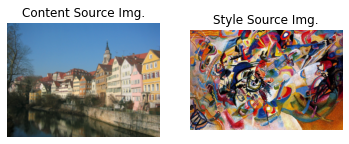

Iteration 0


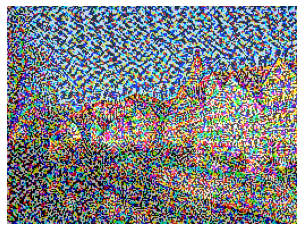

Iteration 100


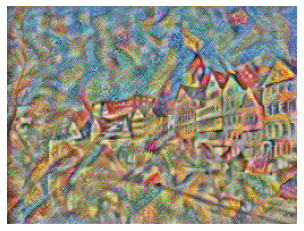

Iteration 199


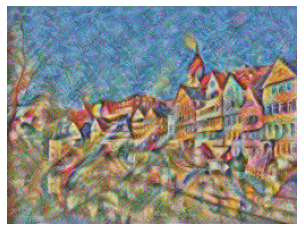

In [20]:
# Composition VII + Tubingen
!wget https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg -O tubingen.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg -O composition_vii.jpg

params1 = {
    'content_image' : 'tubingen.jpg',
    'style_image' : 'composition_vii.jpg',
    'image_size' : 192,
    'style_size' : 512,
    'content_layer' : 'conv_2',
    'content_weight' : 5e-2,
    'style_layers' : ['conv_1', 'conv_3', 'conv_5', 'conv_7'],
    'style_weights' : (20000, 500, 1200, 1000),
    'tv_weight' : 5e-2
}

style_transfer(**params1)

--2022-05-12 22:10:09--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1920px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1388211 (1.3M) [image/jpeg]
Saving to: ‘starry_night.jpg’

starry_night.jpg    100%[===================>]   1.32M  --.-KB/s    in 0.1s    

2022-05-12 22:10:10 (11.4 MB/s) - ‘starry_night.jpg’ saved [1388211/1388211]



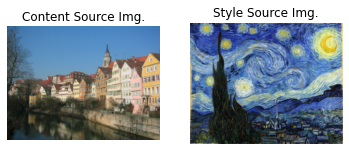

Iteration 0


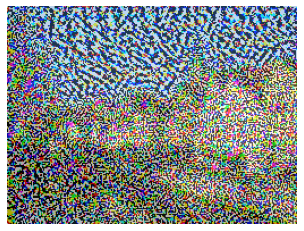

Iteration 100


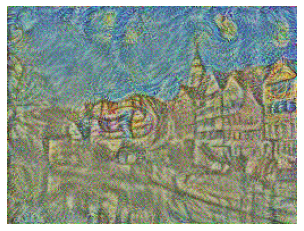

Iteration 199


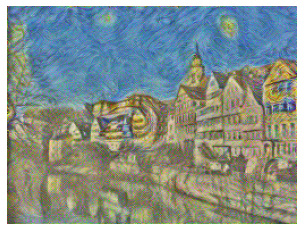

In [21]:
# Starry Night + Tubingen
!wget https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg -O tubingen.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1920px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg -O starry_night.jpg

params3 = {
    'content_image' : 'tubingen.jpg',
    'style_image' : 'starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 'conv_2',
    'content_weight' : 6e-2,
    'style_layers' : ['conv_1', 'conv_4', 'conv_5', 'conv_8'],
    'style_weights' : [3000, 1000, 1500, 300],
    'tv_weight' : 2e-2
}

style_transfer(**params3)

## Feature Inversion (Optional Reading)
The code can do another cool thing. In an attempt to understand the types of features that convolutional networks learn to recognize, a paper "[Understanding Deep Image Representations by Inverting Them](https://arxiv.org/pdf/1412.0035.pdf)" attempts to reconstruct an image from its feature representation. We can easily implement this idea using image gradients from the pretrained network, which is exactly what we did above (but with two different feature representations).

Now, if you set the style weights to all be 0 and initialize the starting image to random noise instead of the content source image, you'll reconstruct an image from the feature representation of the content source image. You're starting with total noise, but you should end up with something that looks quite a bit like your original image.

(Similarly, you could do "texture synthesis" from scratch if you set the content weight to 0 and initialize the starting image to random noise, but we won't ask you to do that here.) 

Run the following cell to try out feature inversion.

[1] Aravindh Mahendran, Andrea Vedaldi, "Understanding Deep Image Representations by Inverting Them", CVPR 2015

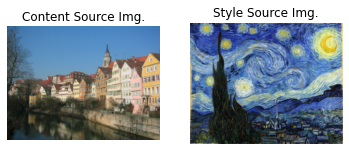

Iteration 0


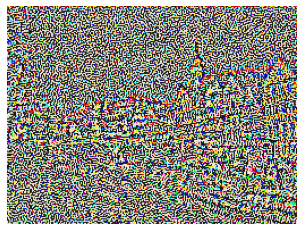

Iteration 100


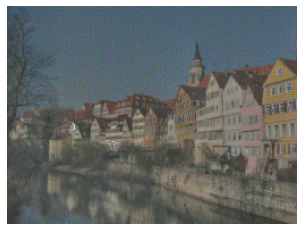

Iteration 199


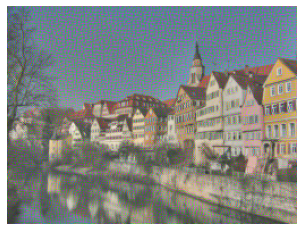

In [22]:
# Feature Inversion -- Starry Night + Tubingen
!wget https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg -O tubingen.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1920px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg -O starry_night.jpg

params_inv = {
    'content_image' : 'tubingen.jpg',
    'style_image' : 'starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 'conv_3',
    'content_weight' : 6e-2,
    'style_layers' : ['conv_1', 'conv_4', 'conv_6', 'conv_7'],
    'style_weights' : [0, 0, 0, 0], # we discard any contributions from style to the loss
    'tv_weight' : 2e-2,
    'init_random': True # we want to initialize our image to be random
}

style_transfer(**params_inv)